In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,vstack
%matplotlib inline
import json
import pandas as pd
import sncosmo
import sys
import os
sys.path.append(os.environ['SEDFIT_DIR'])
import sedfit.utils
import sedfit.mangle
import pickle
from astropy.convolution import Gaussian1DKernel, convolve
from scipy.interpolate import interp2d,interp1d
import spectres
from scipy import signal

In [2]:
example_spectrum = Table.read('example_spectrum',format='ascii')

In [3]:
example_spectrum.colnames

['wavelength', 'flux', 'e_flux']

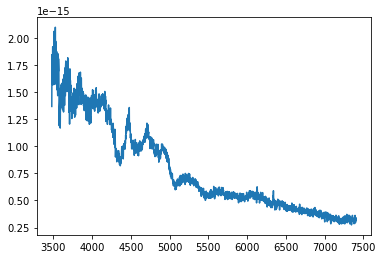

In [4]:
plt.plot(example_spectrum['wavelength'],example_spectrum['flux'])

In [5]:
datafile = 'SN2005hk.json'
data = pd.read_json(datafile)
data = data['SN2005hk']

In [6]:
redshift = float(data['redshift'][0]['value'])
print 'redshift=',redshift

redshift= 0.01306


In [7]:
photometry = pd.read_json(pd.DataFrame(data['photometry']).to_json(),orient='column')
print(photometry.columns)
photometry.rename(columns={x: x.encode('ascii') for x in photometry.columns})
photometry = Table.from_pandas(photometry)    
photometry['Filter'] = photometry['band']
photometry['Mag'] = photometry['magnitude']
photometry['MagErr'] = photometry['e_magnitude']
photometry['MJD'] = photometry['time']
photometry['Survey'] = photometry['telescope']

Index([u'band', u'bandset', u'e_fluxdensity', u'e_magnitude', u'fluxdensity',
       u'frequency', u'instrument', u'magnitude', u'source', u'system',
       u'telescope', u'time', u'u_fluxdensity', u'u_frequency', u'u_time',
       u'upperlimit', u'upperlimitsigma', u'zeropoint'],
      dtype='object')


In [8]:
phot = photometry['Filter','Mag','MagErr','MJD','Survey','system','source'][~photometry['Mag'].mask]
phot['Survey'][phot['source'] == '11,25'] = 'CfA3'
phot['Survey'][phot['Survey'] == 'PAIRITEL'] = 'CfAIR2'
phot = phot['Filter','Mag','MagErr','MJD','Survey'][~phot['Survey'].mask]
phot['Filter'][phot['Survey']=='SDSS'] = [x[0:1] for x in phot['Filter'][phot['Survey']=='SDSS']]
phot['Filter'][phot['Filter']=='Ks'] = 'K_s'
a1 = phot['Filter']
c = ("-" * len(phot))
a2 = phot['Survey']
phot['Filter'] = map(''.join, zip(a2, c, a1))
phot['Filter'][phot['Survey']=='CfA3'] = [x+'K' for x in phot['Filter'][phot['Survey']=='CfA3']]
phot = phot[~phot['MagErr'].mask]
phot['Survey'] = [str(x) for x in phot['Survey']]

In [9]:
cspdata = Table.read('CSP.dat',format='ascii')
a1 = cspdata['Filter']
c = ("-" * len(cspdata))
a2 = cspdata['Survey']
inst = [x[0:1] for x in cspdata['Instrument']]
cspdata['Filter'] = map(''.join, zip(a2, c, a1,inst))

In [10]:
phot = vstack([phot,cspdata],join_type='inner')

In [11]:
# photdata = Table.read('phot.dat',format='ascii')
# a1 = photdata['Filter']
# c = ("-" * len(photdata))
# a2 = photdata['Survey']
# photdata['Instrument'].fill_value = ''
# inst = [x[0:1] for x in photdata['Instrument'].filled()]
# photdata['Filter'] = map(''.join, zip(a2, c, a1,inst))

In [12]:
# phot = photdata.copy()

In [13]:
# for f in set(phot['Filter']):
#     plt.plot(phot['MJD'][phot['Filter']==f],phot['Mag'][phot['Filter']==f],'.',label='osc')
#     plt.plot(photdata['MJD'][photdata['Filter']==f],photdata['Mag'][photdata['Filter']==f],'.',label='orig')
#     plt.ylim(plt.ylim()[::-1])
#     plt.legend()
#     plt.title(f)
#     plt.show()

In [14]:
phot[0:10]

Filter,Mag,MagErr,MJD,Survey
unicode10,float64,float64,float64,str6
SDSS-r,26.301,0.455,53622.344517,SDSS
SDSS-r,26.306,0.577,53622.344517,SDSS
SDSS-r,23.584,0.871,53627.301597,SDSS
CfA3-VK,16.645,0.015,53675.6689,CfA3
CfA3-BK,16.612,0.029,53675.6745,CfA3
CfA3-VK,16.644,0.009,53675.7334,CfA3
CfA3-BK,16.563,0.01,53675.7411,CfA3
SDSS-r,16.592,0.004,53676.328754,SDSS
SDSS-r,16.598,0.004,53676.328754,SDSS


In [15]:
spectra = pd.read_json(pd.DataFrame(data['spectra']).to_json(),orient='column')

In [16]:
spectra.columns

Index([u'data', u'filename', u'instrument', u'observer', u'reducer', u'snr',
       u'source', u'time', u'u_errors', u'u_fluxes', u'u_time',
       u'u_wavelengths'],
      dtype='object')

In [17]:
spectra = spectra.sort_values(by=['time'])
spectra = spectra.reset_index(drop=True)

In [18]:
spectra['data'][0][0:10]

[[u'3480.00', u'1.366944e-15', u'1.8932719e-16'],
 [u'3481.47', u'1.6883218e-15', u'1.9265713e-16'],
 [u'3482.94', u'1.8451346e-15', u'1.9219126e-16'],
 [u'3484.41', u'1.577441e-15', u'1.8965559e-16'],
 [u'3485.88', u'1.7169767e-15', u'1.953534e-16'],
 [u'3487.35', u'1.8165507e-15', u'1.9342538e-16'],
 [u'3488.82', u'1.7250761e-15', u'1.8705049e-16'],
 [u'3490.29', u'1.8846191e-15', u'1.8891832e-16'],
 [u'3491.76', u'1.917305e-15', u'1.8923979e-16'],
 [u'3493.23', u'1.6693629e-15', u'1.8432904e-16']]

In [19]:
set(phot['Survey'])

{'CSP', 'CfA3', 'CfAIR2', 'SDSS', 'Swift'}

In [20]:
# for idx in spectra.index:
#     minwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].min()
#     maxwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].max()
#     print spectra['time'][idx],minwave,maxwave

No data before the peak for band Swift-UVM2
No data before the peak for band Swift-UVW2


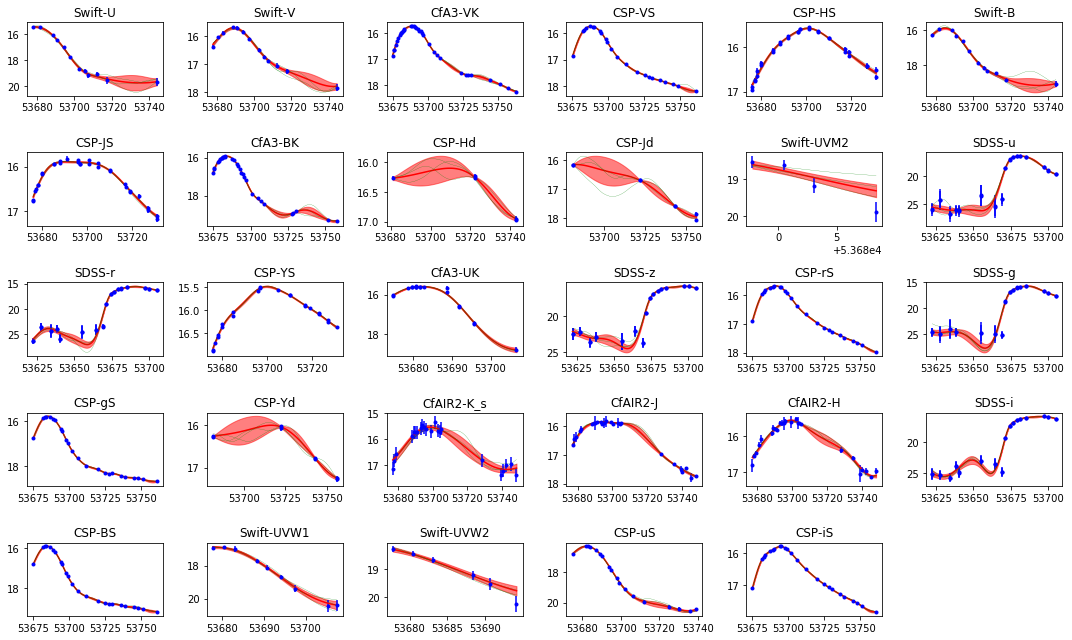

[53678.684458138458, 53688.916427834294, 53688.125221592592, 53687.76583250289, 53700.754729275191, 53684.575569685163, 53690.196393737526, 53683.895715850922, 53709.672149022299, 53683.121985493017, -99.0, 53681.217622904725, 53690.499036251036, 53699.948393094426, 53682.120899791611, 53696.934421912141, 53691.573672799037, 53686.520731075288, 53685.401013256407, 53716.46519561622, 53698.360332908225, 53693.877046316855, 53699.183581801946, 53695.621255159887, 53684.652947632261, 53677.976215961819, -99.0, 53682.248286456183, 53694.688805761929]
[u'Swift-U', u'Swift-V', u'CfA3-VK', u'CSP-VS', u'CSP-HS', u'Swift-B', u'CSP-JS', u'CfA3-BK', u'CSP-Hd', u'CSP-Jd', u'Swift-UVM2', u'SDSS-u', u'SDSS-r', u'CSP-YS', u'CfA3-UK', u'SDSS-z', u'CSP-rS', u'SDSS-g', u'CSP-gS', u'CSP-Yd', u'CfAIR2-K_s', u'CfAIR2-J', u'CfAIR2-H', u'SDSS-i', u'CSP-BS', u'Swift-UVW1', u'Swift-UVW2', u'CSP-uS', u'CSP-iS']
Effective wavelength of bessellb: 4384.77273446
wavelength difference: -36.0419272146
peakmjd: 53684.

In [21]:
reload(sedfit.utils)

# sn = phot[phot['Survey'] == 'CSP'].copy()
sn = phot.copy()

z = redshift

sedfit.utils.register_bands_for_sncosmo()

gpfit_result = sedfit.utils.fit_gp(sn,figsize=(15,9))

plt.show()

gpmeanlc = gpfit_result.meanlc
gpmeanlc_cov = gpfit_result.meanlc_cov
gppeakmjds = gpfit_result.peakmjds
gpfilters = gpfit_result.filters

print gppeakmjds
print gpfilters

peakmjd = sedfit.utils.get_b_band_peakmjd(gpfilters,gppeakmjds,z)
print "peakmjd:", peakmjd
if np.sum(peakmjd>0) == 0:
    print "Can not estimate peak in any band. Stop."


[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']


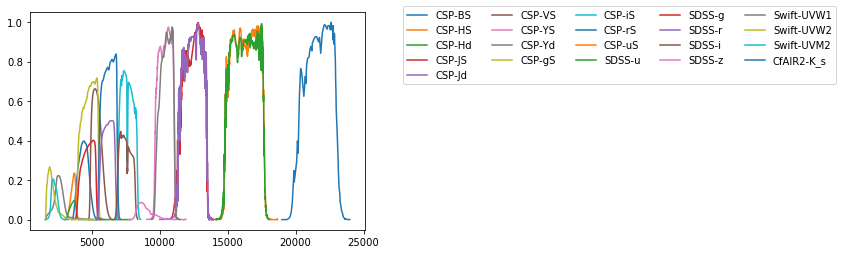

In [22]:
#plot filters
filters = np.unique(sn['Filter'][sn['Survey']=='CSP']).tolist()
filters += ['SDSS-'+x for x in list('ugriz')]
filters += ['Swift-UVW1','Swift-UVW2','Swift-UVM2']
filters += ['CfAIR2-K_s']

sedfit.utils.register_bands_for_sncosmo()

for f in filters:
    band = sncosmo.get_bandpass(f)
    plt.plot(band.wave,band.trans,label=f)
plt.legend(bbox_to_anchor=(1.1, 1.05),ncol=5)
print filters

In [23]:
# (spectra['time']-peakmjd)/(1.+z)

In [24]:
spectra_orig = spectra.copy()

In [25]:
## throw out and combine some spectra with close phases
pthreshold = 0.5
drop_indices = []
newspectra = spectra_orig.iloc[0].copy()
for i,s in enumerate(spectra_orig.iterrows()):
#     print i
    if i == 0:
        continue

    spectrum = s[1]
    phase = spectrum['time']
    sdata = pd.DataFrame(spectrum['data'])
    wave = np.array(sdata[0].astype(float))
    flux = np.array(sdata[1].astype(float))
    
    spectrum_prev = spectra_orig.iloc[i-1]
    phase_prev = spectrum_prev['time']
    sdata_prev = pd.DataFrame(spectrum_prev['data'])
    wave_prev = np.array(sdata_prev[0].astype(float))
    flux_prev = np.array(sdata_prev[1].astype(float))    
    
    dphase = (phase-phase_prev)/(1.+redshift)
    
    if np.abs(dphase) < pthreshold:
#         print phase,wave[0],wave[-1]
#         print phase_prev,wave_prev[0],wave_prev[-1]
        if (wave[0]-wave_prev[0])*(wave[-1]-wave_prev[-1]) > 0:
            if wave[0] < wave_prev[0]:
                idxl = np.argmin(np.abs(wave-wave_prev[0]))
                idxr = np.argmin(np.abs(wave-wave_prev[-1]))
                newwave = np.concatenate((wave[0:idxl],wave_prev),axis=0)
                scale = flux_prev[0]/flux[idxl]
                newflux = np.concatenate((flux[0:idxl]*scale,flux_prev),axis=0)
                newphase = np.mean([phase_prev,phase])
                newspectrum = spectrum_prev.copy()
                newspectrum['time'] = newphase
                newspectrum['data'] = zip(newwave,newflux)
            else:
                idxl = np.argmin(np.abs(wave_prev-wave[0]))
                idxr = np.argmin(np.abs(wave_prev-wave[-1]))
                newwave = np.concatenate((wave_prev[0:idxl],wave),axis=0)
                scale = flux[0]/flux_prev[idxl]
                newflux = np.concatenate((flux_prev[0:idxl]*scale,flux),axis=0)
                newphase = np.mean([phase_prev,phase])
                newspectrum = spectrum.copy()
                newspectrum['time'] = newphase
                newspectrum['data'] = zip(newwave,newflux)
#             print newphase
            drop_indices+=[i-1,i]
            newspectra = pd.concat([newspectra,newspectrum],ignore_index=True,axis=1)
#             plt.plot(newwave,newflux)
#             plt.show()
        else:
            if wave[0] < wave_prev[0]:
                drop_indices.append(i-1)
            else:
                drop_indices.append(i)   
newspectra = newspectra.transpose().iloc[1:]
drop_indices = np.unique(drop_indices).tolist()
print drop_indices
spectra = spectra_orig.drop(drop_indices)
spectra = pd.concat([spectra,newspectra])
spectra = spectra.sort_values(by=['time'])
spectra = spectra.reset_index(drop=True)

[1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 29]


In [26]:
# print (spectra['time']-peakmjd)/(1.+z)

In [27]:
##add extra spectra from SN2011ay
datafile_11ay = '../SN2011ay/SN2011ay.json'
data_11ay = pd.read_json(datafile_11ay)
data_11ay = data_11ay['SN2011ay']
spectra_11ay = pd.read_json(pd.DataFrame(data_11ay['spectra']).to_json(),orient='column')
redshift_11ay = float(data_11ay['redshift'][0]['value'])

In [28]:
##convert to 05hk obs frame  
peakmjd_11ay = 55647.0
spectra_11ay = spectra_11ay.sort_values(by=['time'])
spectra_11ay = spectra_11ay.iloc[0:3]
spectra_11ay_orig = spectra_11ay.copy()
for i,s in enumerate(spectra_11ay_orig.iterrows()):
    spectrum = s[1]
    phase = (spectrum['time']-peakmjd_11ay)/(1.+redshift_11ay)
    mjd = peakmjd+phase*(1.+redshift)
    sdata = pd.DataFrame(spectrum['data'])
    wave = sdata[0].astype(float)
    flux = sdata[1].astype(float)
    newwave = wave/(1.+redshift_11ay)*(1.+redshift)
    spectra_11ay['time'].iloc[i] = mjd
    spectra_11ay['data'].iloc[i] = zip(newwave,flux)


/home/mi/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
spectra = pd.concat([spectra,spectra_11ay],ignore_index=True)
spectra = spectra.sort_values(by=['time'])
spectra = spectra.reset_index(drop=True)

bessellb scale= 340167113.294
bessellv scale= 348490450.642
bessellr scale= 353415207.397
besselli scale= 380166504.356


/home/mi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


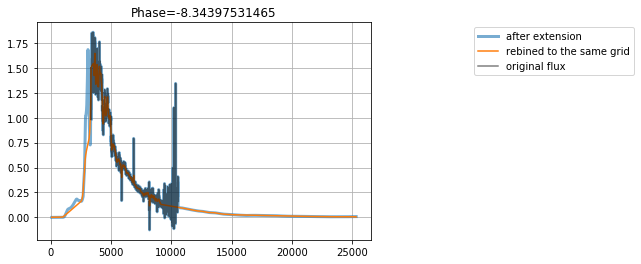

bessellb scale= 3.99218000081e-07
bessellv scale= 4.30448388879e-07
bessellr scale= 4.79899680574e-07
besselli scale= 5.16389631779e-07


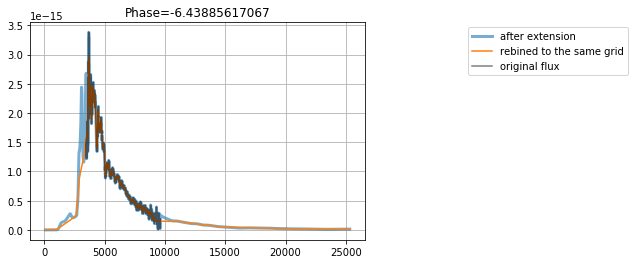

bessellb scale= 385736325.061
bessellv scale= 475355038.279
bessellr scale= 513870211.15
besselli scale= 586904370.667


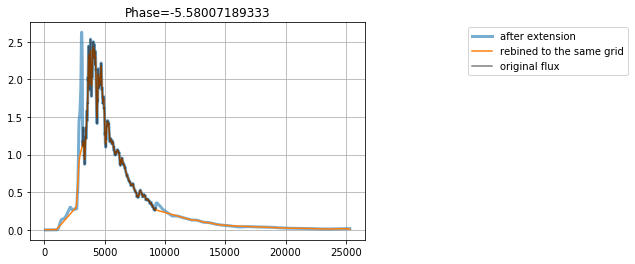

bessellb scale= 3.85395885186e-07
bessellv scale= 4.44125020514e-07
bessellr scale= 4.78644747178e-07
besselli scale= 5.43403170873e-07


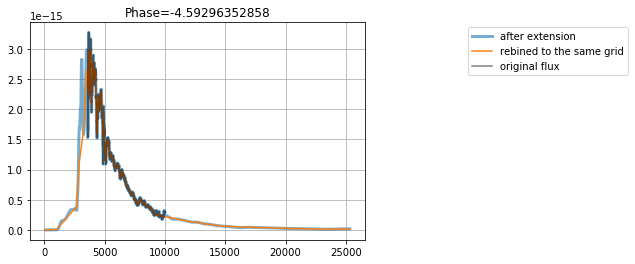

bessellb scale= 3.7482348416e-07
bessellv scale= 4.36661031002e-07
bessellr scale= 4.75864667063e-07
besselli scale= 5.46083094715e-07


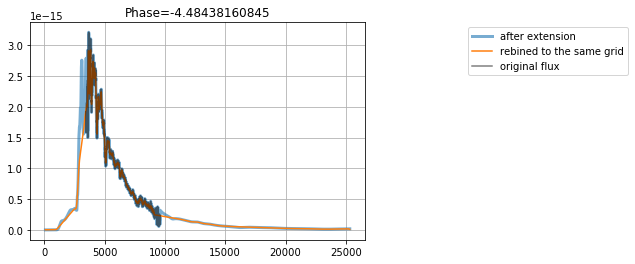

bessellb scale= 139977665658.0
bessellv scale= 150697930051.0
bessellr scale= 161850847713.0
besselli scale= 189291111090.0


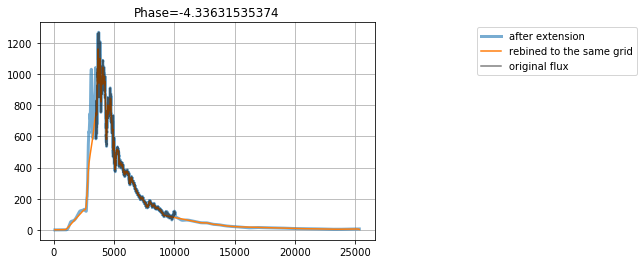

bessellb scale= 6996645260.18
bessellv scale= 7363271742.93
bessellr scale= 7891480948.04
besselli scale= 9266873179.57


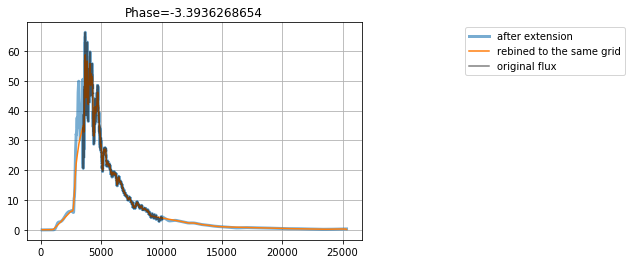

bessellb scale= 7057628218.22
bessellv scale= 7780467778.14
bessellr scale= 8584268093.62
besselli scale= 10887824904.9


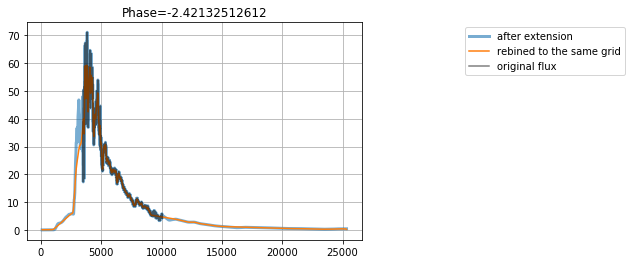

bessellb scale= 141898044.037
bessellv scale= 208450740.627
bessellr scale= 259124319.711
besselli scale= 429149160.789


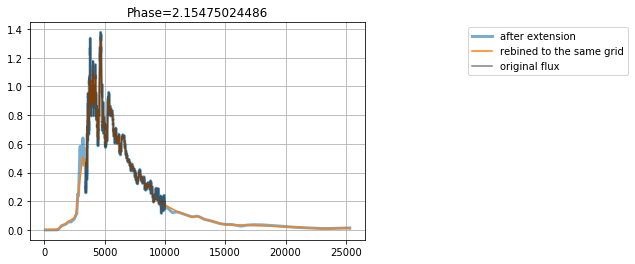

bessellb scale= 119272796.993
bessellv scale= 197817615.0
bessellr scale= 263286538.273
besselli scale= 471167876.219


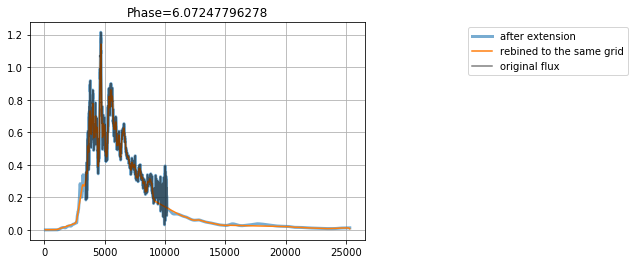

bessellb scale= 146386072.552
bessellv scale= 281331167.814
bessellr scale= 428652187.425
besselli scale= 782021393.893


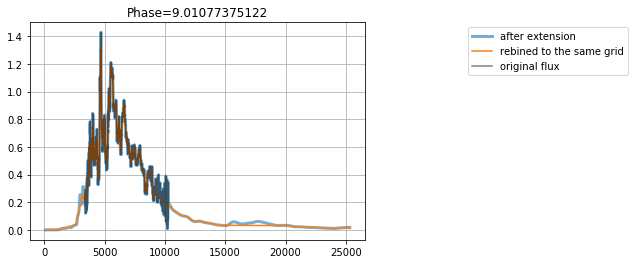

bessellb scale= 2.4706748505e-07
bessellv scale= 4.98616519562e-07
bessellr scale= 8.81363233924e-07
besselli scale= 1.56843920466e-06


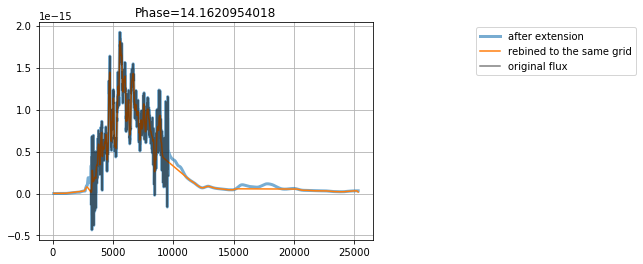

bessellv scale= 19847434.0035
bessellr scale= 31145280.4067
besselli scale= 45323754.286


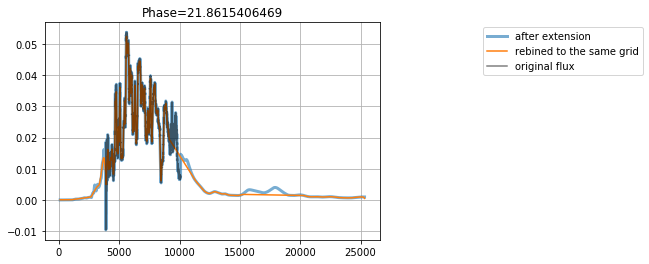

bessellb scale= 2.68684405292e-07
bessellv scale= 4.31897945622e-07
bessellr scale= 6.3602992954e-07
besselli scale= 9.17069869004e-07


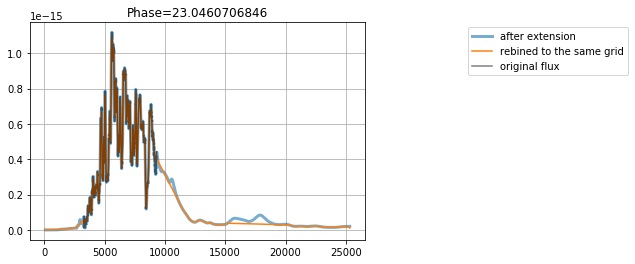

bessellb scale= 255591531.167
bessellv scale= 432694011.327
bessellr scale= 643846626.524
besselli scale= 897686540.45


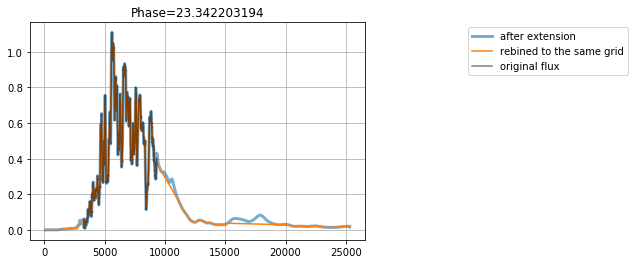

bessellv scale= 5.8079142324e-07
bessellr scale= 7.10408534176e-07
besselli scale= 7.77082134362e-07


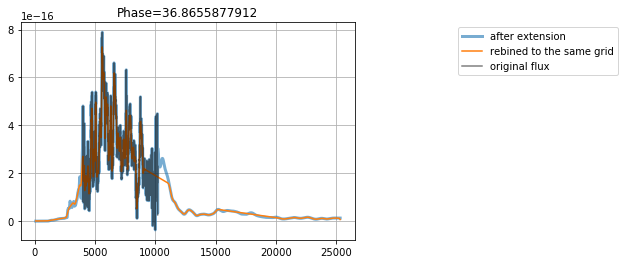

bessellv scale= 6.00942233881e-07
bessellr scale= 7.55367073784e-07
besselli scale= 8.61673879284e-07


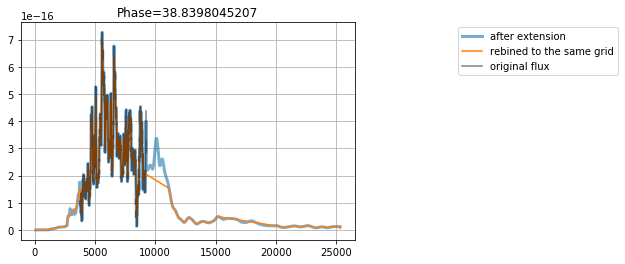

bessellv scale= 6.34749054375e-07
bessellr scale= 7.84697036262e-07
besselli scale= 9.48270731531e-07


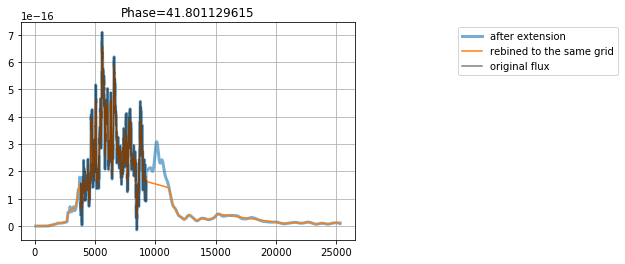

bessellv scale= 6.38440760222e-07
bessellr scale= 7.88478105276e-07
besselli scale= 9.90973801983e-07


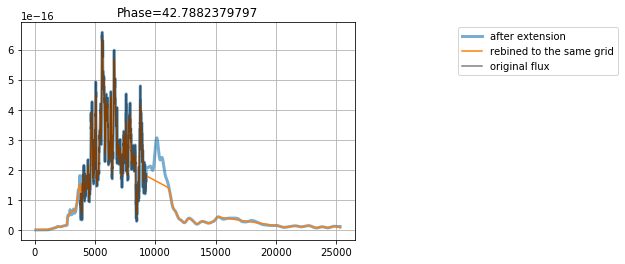

bessellv scale= 3769615706.31
bessellr scale= 4634913751.75


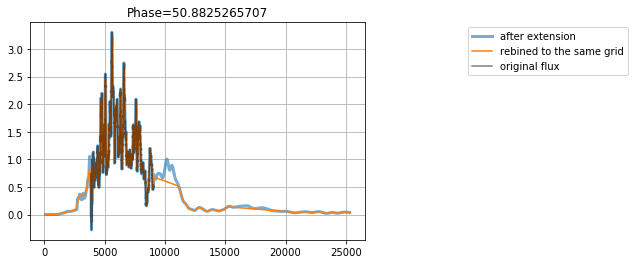

bessellv scale= 7.62168040668e-07
bessellr scale= 9.63792853074e-07
besselli scale= 1.48426323841e-06


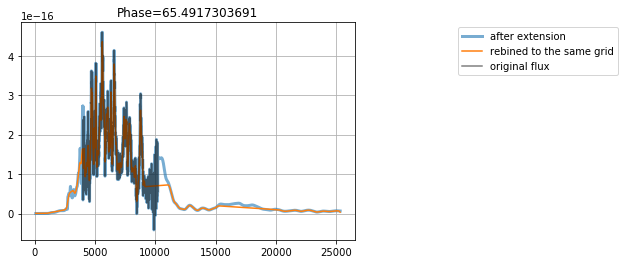

bessellb scale= 6287433.81628
bessellv scale= 16482164.6707
bessellr scale= 36818169.1352
besselli scale= 97572700.0084


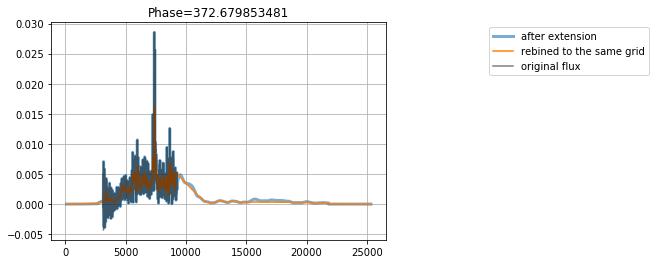

(22, 12)


In [30]:
## Extend spectra using Hsiao model, cut out bad features, and smooth

minw = 4000
maxw = 8000
hminw = 1000
hmaxw = 25000
outphases = []
spectra_extended = spectra.iloc[0].copy()

for i,s in enumerate(spectra.iterrows()):
   
    spectrum = s[1]
    phase = (spectrum['time']-peakmjd)/(1.+ z)

    sdata = pd.DataFrame(spectrum['data'])
    wave = np.array(sdata[0].astype(float))
    flux = np.atleast_2d(sdata[1].astype(float))
   
    minwave = wave.min()
    maxwave = wave.max()
    
    if minwave>minw or maxwave<maxw:
        continue

    nrepeat = 5
    phasearr = np.linspace(-50.,100.,nrepeat)
    
    newsource = sncosmo.TimeSeriesSource(phasearr,wave,np.repeat(flux,nrepeat,axis=0))
    newsed_at_p = sncosmo.Model(newsource)
    
    hsed = sncosmo.Model(source='hsiao')
    hsed.set(z=redshift)
    hwave = np.linspace(hminw*(1.+redshift),hmaxw*(1.+redshift),3000)
    hflux = hsed.flux(phase,hwave)
    
    scales = []
    for b in ['B','V','R','I']:
        band = sncosmo.get_bandpass('Bessell'+b)
        if wave.min() > band.wave.min() or wave.max()< band.wave.max():
            continue
        synmag = newsed_at_p.bandmag(band,'ab',phase)
        hsynmag = hsed.bandmag(band,'ab',phase)
        scale = np.power(10.,-0.4*(synmag-hsynmag))
        print band.name,"scale=",scale
        scales.append(scale)
    
    if len(scales) <=1:
        continue

    # extend to hsiao limit
    idxl = np.argmin(np.abs(hwave-wave[0]))
    idxr = np.argmin(np.abs(hwave-wave[-1]))
    newwave = np.concatenate((hwave[:idxl-1],wave[1:-1],hwave[idxr+1:]),axis=0)
    newflux = np.concatenate((hflux[:idxl-1]*scales[0],flux.ravel()[1:-1],hflux[idxr+1:]*scales[-1]),axis=0)
    
    # extend a little further (add some zeros)
    uvwave = np.linspace(100.,hwave[0],50.)
    uvflux = np.zeros(len(uvwave))
    newwave = np.concatenate((uvwave,newwave),axis=0)
    newflux = np.concatenate((uvflux,newflux),axis=0)

    plt.title("Phase={}".format(phase))      
    plt.plot(newwave,newflux,label='after extension',lw=3,alpha=0.6)

    newflux = np.clip(newflux,np.max(newflux)*0.001,np.inf)
#     plt.plot(newwave,newflux,label='after clipping negative flux')

    restwave = newwave/(1.+redshift)
    qq = np.where(  ((restwave < 3750.) | (restwave > 3800.)) 
                  & ((restwave < 9000.) | (restwave > 11000.))
                  & ((restwave < 3300.) | (restwave > 3500.)) 
                  & ((restwave < 15000.) | (restwave > 20000.)) 
                  & ((restwave < 1005.) | (restwave > 2500.)) 
                  & ((restwave < 2800.) | (restwave > 3200.)) )

    
    newflux_interp = np.interp(newwave,newwave[qq],newflux[qq])
    newflux_interp = np.clip(newflux_interp,np.max(newflux_interp)*0.001,np.inf)
#     plt.plot(newwave,newflux_interp,label='after cutting out bad features')
    
    #smooth the spectra
    g = Gaussian1DKernel(stddev=8)
    newflux_smoothed = convolve(newflux_interp, g)         
#     plt.plot(newwave,newflux_smoothed,label='smoothed using Gaussian1DKernel',lw=4,alpha=0.7)
    
    #rebin spectra to the same grid
    newwave_rebin = np.linspace(newwave.min(),newwave.max(),2000)
    newflux_rebin = spectres.spectres(newwave_rebin[1:-1], newwave, newflux_smoothed) 
    newflux_rebin = np.insert(newflux_rebin,0,newflux_smoothed[0])
    newflux_rebin = np.append(newflux_rebin,newflux_smoothed[-1])
    newflux_rebin = np.clip(newflux_rebin,np.max(newflux_rebin)*0.001,np.inf)   
    plt.plot(newwave_rebin,newflux_rebin,label='rebined to the same grid')
             
    newspectrum = spectrum.copy()
    newspectrum['data'] = zip(newwave_rebin,newflux_rebin)
        
    spectra_extended = pd.concat([spectra_extended,newspectrum],ignore_index=True,axis=1)  
      
#     plt.plot(hwave,hflux*scales[0],label='uv')
#     plt.plot(hwave,hflux*scales[-1],label='ir')
#     plt.legend()

    plt.plot(wave,flux.ravel(),label='original flux',alpha=0.5,color='k')
#     plt.xlim(hminw,hmaxw)
    plt.legend(bbox_to_anchor=(1.8, 1.))
    plt.grid()
    plt.show()

    outphases.append(phase)
spectra_extended = spectra_extended.transpose().iloc[1:]
print spectra_extended.shape

In [31]:
# print len(outphases)
# print outphases

In [32]:
## add earlier phases using the first spectrum
for phase in [-15.,-11.]:
    spectrum0 = spectra_extended.iloc[0].copy()
    mjd = peakmjd + phase*(1.+redshift)
    sdata = pd.DataFrame(spectrum0['data'])
    wave = sdata[0].astype(float)
    flux = sdata[1].astype(float)
    spectrum0['time'] = mjd
    spectra_extended = spectra_extended.append(spectrum0)
spectra_extended = spectra_extended.sort_values(by=['time'])
spectra_extended = spectra_extended.reset_index(drop=True)

In [33]:
# spectra_extended

Phase= -15.0
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53669.4570476 out of data range [53675.11,53761.04].
Phase 53669.4570476 out of data range [53676.0,53731.08].
Phase 53669.4570476 out of data range [53681.08,53743.07].
Phase 53669.4570476 out of data range [53676.0,53731.08].
Phase 53669.4570476 out of data range [53681.08,53756.07].
Phase 53669.4570476 out of data range [53675.11,53761.04].
Phase 53669.4570476 out of data range [53676.0,53731.06].
Phase 53669.4570476 out of data range [53681.08,53756.07].
Phase 53669.4570476 out of data range [53675.11,53761.04].
Phase 53669.4570476 out of data range [53675.11,53761.04].
Phase 53669.4570476 out of data range [53675.11,53761.04].
Phase 53669.4570476 out of data range [53675.11,53739.06].
Phase 53669.4570476 out of data range [5367

/home/mi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


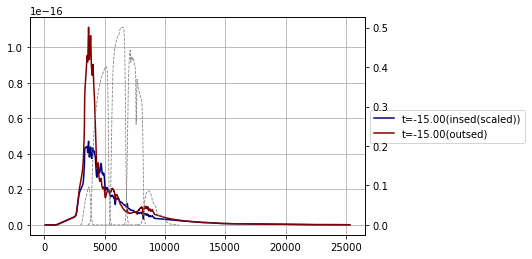

Phase= -11.0
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53673.5092876 out of data range [53675.11,53761.04].
Phase 53673.5092876 out of data range [53676.0,53731.08].
Phase 53673.5092876 out of data range [53681.08,53743.07].
Phase 53673.5092876 out of data range [53676.0,53731.08].
Phase 53673.5092876 out of data range [53681.08,53756.07].
Phase 53673.5092876 out of data range [53675.11,53761.04].
Phase 53673.5092876 out of data range [53676.0,53731.06].
Phase 53673.5092876 out of data range [53681.08,53756.07].
Phase 53673.5092876 out of data range [53675.11,53761.04].
Phase 53673.5092876 out of data range [53675.11,53761.04].
Phase 53673.5092876 out of data range [53675.11,53761.04].
Phase 53673.5092876 out of data range [53675.11,53739.06].
Phase 53673.5092876 out of data range [5367

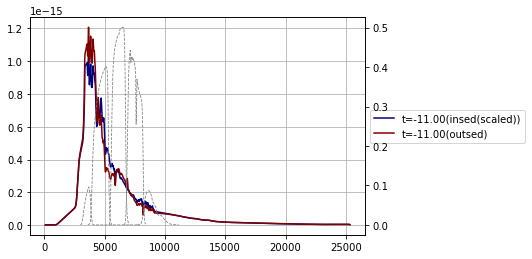

Phase= -8.34397531465
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53676.2 out of data range [53681.08,53743.07].
Phase 53676.2 out of data range [53681.08,53756.07].
Phase 53676.2 out of data range [53681.08,53756.07].
Phase 53676.2 out of data range [53677.7652,53707.4586].
Phase 53676.2 out of data range [53677.7824,53694.1159].
Phase 53676.2 out of data range [53677.7616,53688.3762].
Phase 53676.2 out of data range [53677.09,53748.17].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988  16277.18197817]
Phase = -8.34397531465
Phot_at_p:
    Phase  

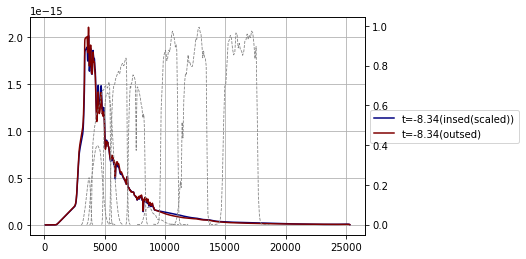

Phase= -6.43885617067
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53678.13 out of data range [53681.08,53743.07].
Phase 53678.13 out of data range [53681.08,53756.07].
Phase 53678.13 out of data range [53681.08,53756.07].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVM2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2254.78024788   2613.71306053   3628.67221495
   4405.52523159   4794.04150564   5389.26524088   6239.34112913
   7630.76341788   8918.30148441  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Phase = -6.43885617067
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- -------

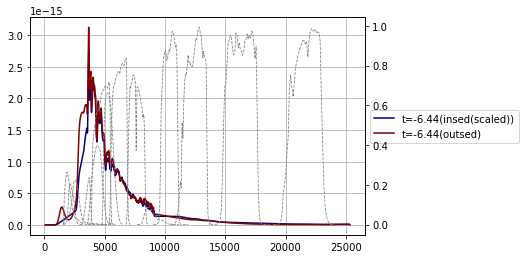

Phase= -5.58007189333
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53679.0 out of data range [53681.08,53743.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVM2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2254.78024788   2613.71306053   3628.67221495
   4405.52523159   4794.04150564   5389.26524088   6239.34112913
   7630.76341788   8918.30148441  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Phase = -5.58007189333
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- ----------

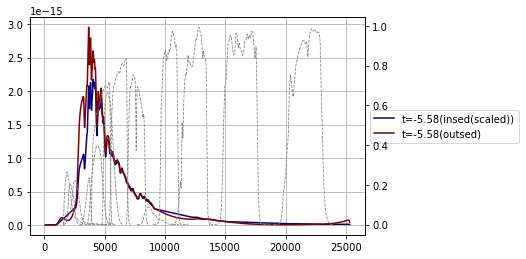

Phase= -4.59296352858
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53680.0 out of data range [53681.08,53743.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2613.71306053   3628.67221495   4405.52523159
   4794.04150564   5389.26524088   6239.34112913   7630.76341788
   8918.30148441  10388.61644953  12452.52755988  16277.18197817
  21656.10519189]
Phase = -4.59296352858
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- ---------------- ------
-4.59296352858 S

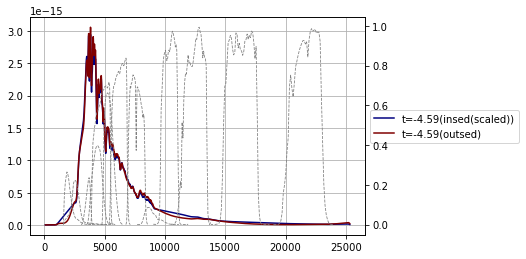

Phase= -4.48438160845
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53680.11 out of data range [53681.08,53743.07].
Phase 53680.11 out of data range [53681.08,53756.07].
Phase 53680.11 out of data range [53681.08,53756.07].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2613.71306053   3628.67221495   4405.52523159
   4794.04150564   5389.26524088   6239.34112913   7630.76341788
   8918.30148441  10388.61644953  12452.52755988  16277.18197817
  21656.10519189]
Phase = -4.48438160845
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- ---------------- ------
-4.4843816084

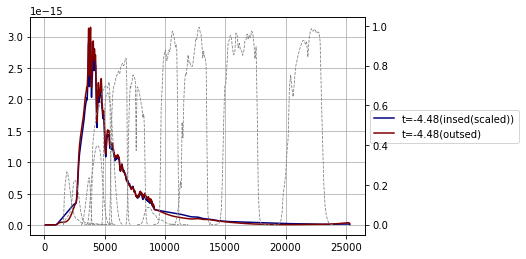

Phase= -4.33631535374
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53680.26 out of data range [53681.08,53743.07].
Phase 53680.26 out of data range [53681.08,53756.07].
Phase 53680.26 out of data range [53681.08,53756.07].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2613.71306053   3628.67221495   4405.52523159
   4794.04150564   5389.26524088   6239.34112913   7630.76341788
   8918.30148441  10388.61644953  12452.52755988  16277.18197817
  21656.10519189]
Phase = -4.33631535374
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- ---------------- ------
-4.3363153537

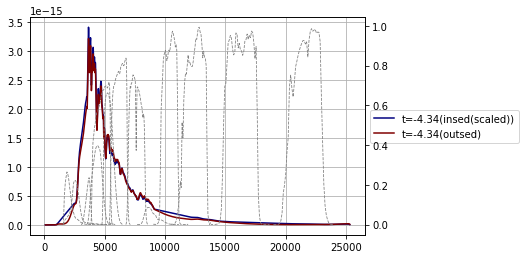

Phase= -3.3936268654
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVM2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2254.78024788   2613.71306053   3628.67221495
   4405.52523159   4794.04150564   5389.26524088   6239.34112913
   7630.76341788   8918.30148441  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Phase = -3.3936268654
Phot_at_p:
    Phase       Filter        Mag           MagErr      sortid
------------- ---------- ------------- ---------------- ------
-3.3936268654 Swift-UVW2 18.5286580732  0.0626666227913      0
-3.3936268654 Swift-UVM2 18.8331388208  0.0863734803785      1
-3.3936268654 Swift-UVW

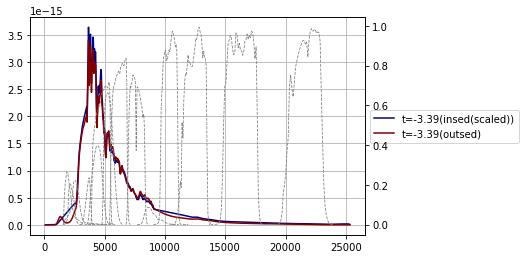

Phase= -2.42132512612
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVM2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2254.78024788   2613.71306053   3628.67221495
   4405.52523159   4794.04150564   5389.26524088   6239.34112913
   7630.76341788   8918.30148441  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Phase = -2.42132512612
Phot_at_p:
    Phase        Filter        Mag           MagErr      sortid
-------------- ---------- ------------- ---------------- ------
-2.42132512612 Swift-UVW2 18.6140120854  0.0649047165557      0
-2.42132512612 Swift-UVM2 18.9025305292  0.0909538922108      1
-2.42132512612 Sw

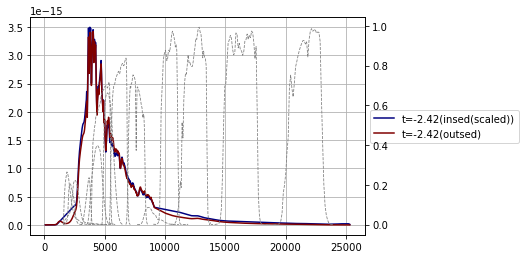

Phase= 2.15475024486
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVM2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2254.78024788   2613.71306053   3628.67221495
   4405.52523159   4794.04150564   5389.26524088   6239.34112913
   7630.76341788   8918.30148441  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Phase = 2.15475024486
Phot_at_p:
    Phase       Filter        Mag           MagErr      sortid
------------- ---------- ------------- ---------------- ------
2.15475024486 Swift-UVW2 19.0753706463  0.0850568673508      0
2.15475024486 Swift-UVM2  19.225807258   0.148228367397      1
2.15475024486 Swift-UVW

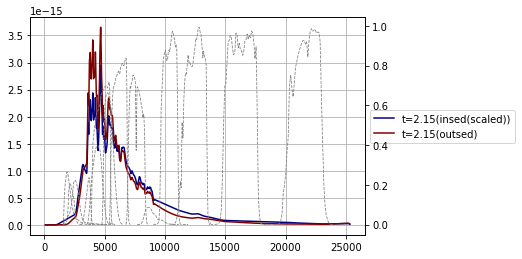

Phase= 6.07247796278
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53690.8047322 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2613.71306053   3628.67221495   4405.52523159
   4794.04150564   5389.26524088   6239.34112913   7630.76341788
   8918.30148441  10388.61644953  12452.52755988  16277.18197817
  21656.10519189]
Phase = 6.07247796278
Phot_at_p:
    Phase       Filter        Mag           MagErr      sortid
------------- ---------- ------------- ---------------- ------
6.07247796278 Swift-UVW2 19.4810117751   0.114648289752      0
6.07247796278 Swift-UVW1 18.1269022603  0.07159095175

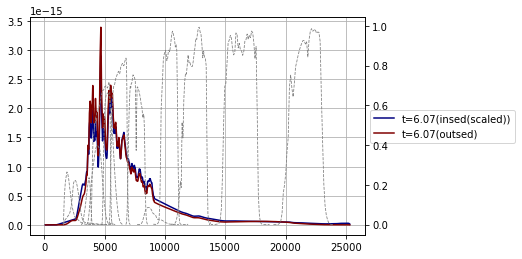

Phase= 9.01077375122
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53693.7814021 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['Swift-UVW2', 'Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2079.87543327   2613.71306053   3628.67221495   4405.52523159
   4794.04150564   5389.26524088   6239.34112913   7630.76341788
   8918.30148441  10388.61644953  12452.52755988  16277.18197817
  21656.10519189]
Phase = 9.01077375122
Phot_at_p:
    Phase       Filter        Mag           MagErr      sortid
------------- ---------- ------------- ---------------- ------
9.01077375122 Swift-UVW2 19.7394578915    0.15866208979      0
9.01077375122 Swift-UVW1 18.6649557162  0.08933161325

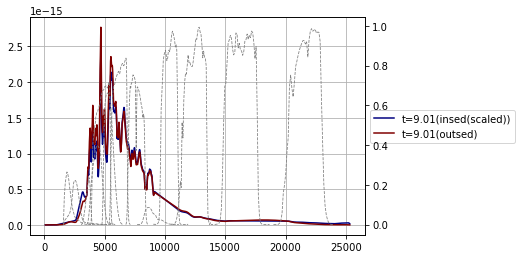

Phase= 14.1620954018
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53699.0 out of data range [53677.7824,53694.1159].
Phase 53699.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'SDSS-z', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   4794.04150564   5389.26524088
   6239.34112913   7630.76341788   8918.30148441  10388.61644953
  12452.52755988  16277.18197817  21656.10519189]
Phase = 14.1620954018
Phot_at_p:
    Phase       Filter        Mag           MagErr      sortid
------------- ---------- ------------- ---------------- ------
14.1620954018     CSP-uS 18.6068898072  0.0287580764515      0
14.1620954018     CSP-BS 17.4112491849 0.00635069189091      1


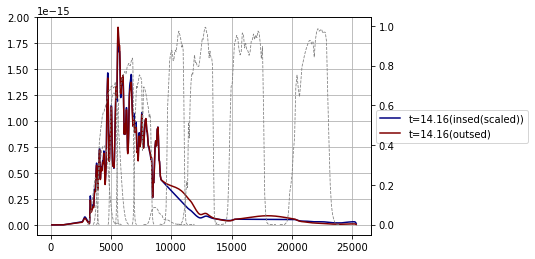

Phase= 21.8615406469
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53706.8 out of data range [53622.346176,53705.234353].
Phase 53706.8 out of data range [53622.347834,53705.236011].
Phase 53706.8 out of data range [53622.344517,53705.232695].
Phase 53706.8 out of data range [53622.345346,53705.233524].
Phase 53706.8 out of data range [53622.347005,53705.235182].
Phase 53706.8 out of data range [53677.7824,53694.1159].
Phase 53706.8 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['Swift-UVW1', 'CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  2613.71306053   3628.67221495   4405.52523159   5389.26524088
   6239.34112913   7630.76341788  10388.61644953  12452.52755988
  16277.18197817  21656.10519189]
Ph

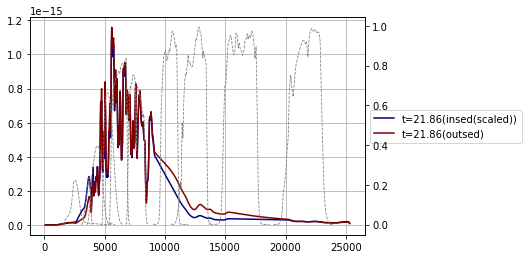

Phase= 23.0460706846
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53708.0 out of data range [53622.346176,53705.234353].
Phase 53708.0 out of data range [53622.347834,53705.236011].
Phase 53708.0 out of data range [53622.344517,53705.232695].
Phase 53708.0 out of data range [53622.345346,53705.233524].
Phase 53708.0 out of data range [53622.347005,53705.235182].
Phase 53708.0 out of data range [53677.7652,53707.4586].
Phase 53708.0 out of data range [53677.7824,53694.1159].
Phase 53708.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.18

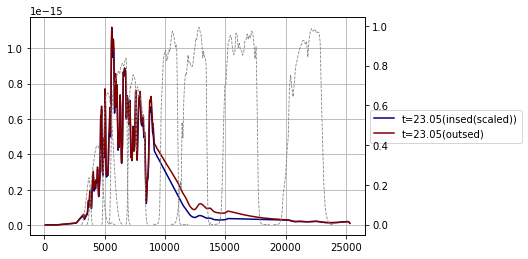

Phase= 23.342203194
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53708.3 out of data range [53622.346176,53705.234353].
Phase 53708.3 out of data range [53622.347834,53705.236011].
Phase 53708.3 out of data range [53622.344517,53705.232695].
Phase 53708.3 out of data range [53622.345346,53705.233524].
Phase 53708.3 out of data range [53622.347005,53705.235182].
Phase 53708.3 out of data range [53677.7652,53707.4586].
Phase 53708.3 out of data range [53677.7824,53694.1159].
Phase 53708.3 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.181

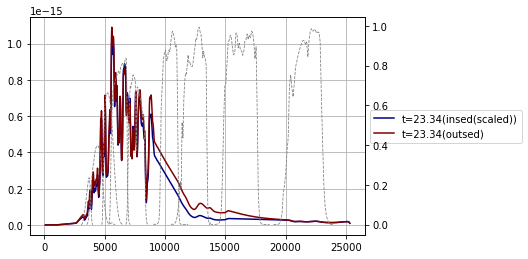

Phase= 36.8655877912
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53722.0 out of data range [53622.346176,53705.234353].
Phase 53722.0 out of data range [53622.347834,53705.236011].
Phase 53722.0 out of data range [53622.344517,53705.232695].
Phase 53722.0 out of data range [53622.345346,53705.233524].
Phase 53722.0 out of data range [53622.347005,53705.235182].
Phase 53722.0 out of data range [53677.7652,53707.4586].
Phase 53722.0 out of data range [53677.7824,53694.1159].
Phase 53722.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.18

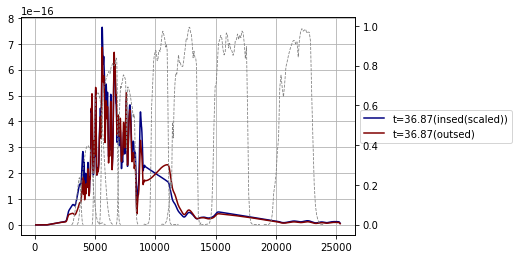

Phase= 38.8398045207
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53724.0 out of data range [53622.346176,53705.234353].
Phase 53724.0 out of data range [53622.347834,53705.236011].
Phase 53724.0 out of data range [53622.344517,53705.232695].
Phase 53724.0 out of data range [53622.345346,53705.233524].
Phase 53724.0 out of data range [53622.347005,53705.235182].
Phase 53724.0 out of data range [53677.7652,53707.4586].
Phase 53724.0 out of data range [53677.7824,53694.1159].
Phase 53724.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.18

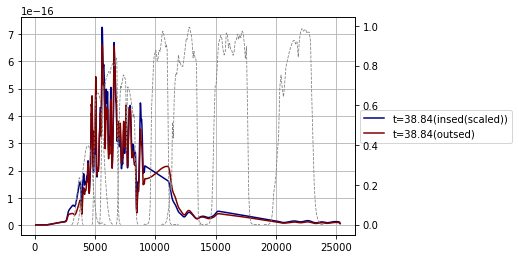

Phase= 41.801129615
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53727.0 out of data range [53622.346176,53705.234353].
Phase 53727.0 out of data range [53622.347834,53705.236011].
Phase 53727.0 out of data range [53622.344517,53705.232695].
Phase 53727.0 out of data range [53622.345346,53705.233524].
Phase 53727.0 out of data range [53622.347005,53705.235182].
Phase 53727.0 out of data range [53677.7652,53707.4586].
Phase 53727.0 out of data range [53677.7824,53694.1159].
Phase 53727.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.181

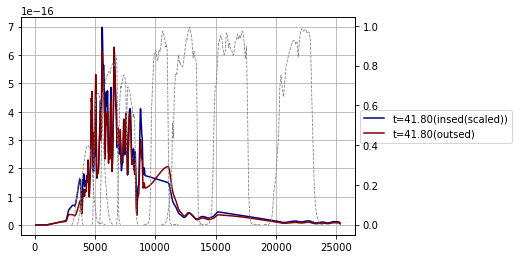

Phase= 42.7882379797
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53728.0 out of data range [53622.346176,53705.234353].
Phase 53728.0 out of data range [53622.347834,53705.236011].
Phase 53728.0 out of data range [53622.344517,53705.232695].
Phase 53728.0 out of data range [53622.345346,53705.233524].
Phase 53728.0 out of data range [53622.347005,53705.235182].
Phase 53728.0 out of data range [53677.7652,53707.4586].
Phase 53728.0 out of data range [53677.7824,53694.1159].
Phase 53728.0 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-YS', 'CSP-JS', 'CSP-HS', 'CfAIR2-K_s']
efflam =  [  3628.67221495   4405.52523159   5389.26524088   6239.34112913
   7630.76341788  10388.61644953  12452.52755988  16277.18

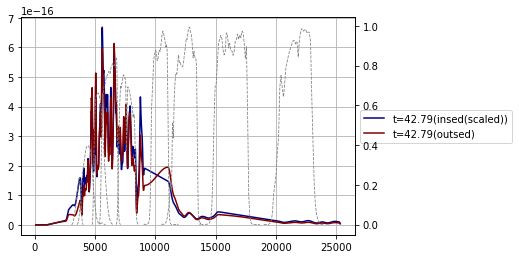

Phase= 50.8825265707
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53736.2 out of data range [53676.0,53731.08].
Phase 53736.2 out of data range [53676.0,53731.08].
Phase 53736.2 out of data range [53676.0,53731.06].
Phase 53736.2 out of data range [53622.346176,53705.234353].
Phase 53736.2 out of data range [53622.347834,53705.236011].
Phase 53736.2 out of data range [53622.344517,53705.232695].
Phase 53736.2 out of data range [53622.345346,53705.233524].
Phase 53736.2 out of data range [53622.347005,53705.235182].
Phase 53736.2 out of data range [53677.7652,53707.4586].
Phase 53736.2 out of data range [53677.7824,53694.1159].
Phase 53736.2 out of data range [53677.7616,53688.3762].
Bands are out of range []
Filters:  ['CSP-uS', 'CSP-BS', 'CSP-VS', 'CSP-rS', 'CSP-iS', 'CSP-Yd', 'CSP-Jd', '

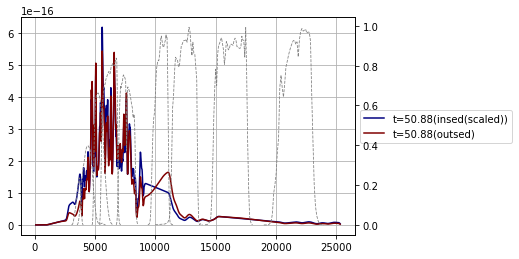

Phase= 65.4917303691
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 53751.0 out of data range [53676.0,53731.08].
Phase 53751.0 out of data range [53681.08,53743.07].
Phase 53751.0 out of data range [53676.0,53731.08].
Phase 53751.0 out of data range [53676.0,53731.06].
Phase 53751.0 out of data range [53675.11,53739.06].
Phase 53751.0 out of data range [53622.346176,53705.234353].
Phase 53751.0 out of data range [53622.347834,53705.236011].
Phase 53751.0 out of data range [53622.344517,53705.232695].
Phase 53751.0 out of data range [53622.345346,53705.233524].
Phase 53751.0 out of data range [53622.347005,53705.235182].
Phase 53751.0 out of data range [53677.7652,53707.4586].
Phase 53751.0 out of data range [53677.7824,53694.1159].
Phase 53751.0 out of data range [53677.7616,53688.3762].
Ph

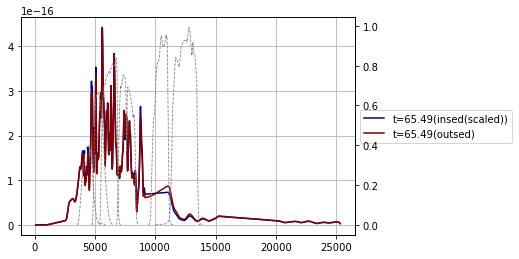

Phase= 372.679853481
[u'CSP-BS', u'CSP-HS', u'CSP-Hd', u'CSP-JS', u'CSP-Jd', u'CSP-VS', u'CSP-YS', u'CSP-Yd', u'CSP-gS', u'CSP-iS', u'CSP-rS', u'CSP-uS', 'SDSS-u', 'SDSS-g', 'SDSS-r', 'SDSS-i', 'SDSS-z', 'Swift-UVW1', 'Swift-UVW2', 'Swift-UVM2', 'CfAIR2-K_s']
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53676.0,53731.08].
Phase 54062.2 out of data range [53681.08,53743.07].
Phase 54062.2 out of data range [53676.0,53731.08].
Phase 54062.2 out of data range [53681.08,53756.07].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53676.0,53731.06].
Phase 54062.2 out of data range [53681.08,53756.07].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53761.04].
Phase 54062.2 out of data range [53675.11,53739.06].
Phase 54062.2 out of data range [53622.346176,53705.234353].
Phase 54062.2 out of data range [53622.347834,

In [34]:
##mangle the spectra
reload(sedfit.mangle)
reload(sedfit.utils)

sedres = []
for s in spectra_extended.iterrows():
# for s in spectra_orig.iterrows():
    
    spectrum = s[1]
      
    phase = (spectrum['time']-peakmjd)/(1.+ z)
    print "Phase=",phase
    
    mags = []
    magerr = []
    goodfilts = []
    print filters
    for i,f in enumerate(filters):
#             print peakmjd
        mjd = phase*(1.+z)+peakmjd
        gpidx = gpfilters.index(f)
        mag = gpmeanlc[gpidx](mjd)
        merr = np.sqrt(gpmeanlc_cov[gpidx](mjd))
        mags.append(mag)
        magerr.append(merr)
        fminmjd = np.min(sn['MJD'][sn['Filter']==f])
        fmaxmjd = np.max(sn['MJD'][sn['Filter']==f])        
        
        if mjd < fminmjd  or mjd > fmaxmjd:
            print "Phase {} out of data range [{},{}].".format(mjd,fminmjd,fmaxmjd)
            goodfilts.append(False)
        else:
            goodfilts.append(True)
    goodfilts = np.array(goodfilts)

    phases = [phase]*len(filters)
    data_table = zip(mags,magerr,filters,phases)      
    synlc = Table(rows = data_table,names=('Mag','MagErr','Filter','Phase'),dtype=('f8', 'f8', 'S30','f8'))
    synlc_good = synlc[goodfilts]
    
    if len(synlc_good) < 2:
        print "Number of available bands is < 2. Skip this phase."
        continue

    nrepeat = 5
    phasearr = np.linspace(-50.,50.,nrepeat)

    sdata = pd.DataFrame(spectrum['data'])

    wave = np.array(sdata[0].astype(float))
    flux = np.atleast_2d(sdata[1].astype(float))

#     plt.plot(wave,flux.ravel())

    newsource = sncosmo.TimeSeriesSource(phasearr,wave,np.repeat(flux,nrepeat,axis=0))
    newsed_at_p = sncosmo.Model(newsource)
#     plt.plot(np.linspace(newsed_at_p.minwave(),newsed_at_p.maxwave(),3000),newsed_at_p.flux(phase,np.linspace(newsed_at_p.minwave(),newsed_at_p.maxwave(),3000)))
#     plt.plot(wave,newsed_at_p.flux(100,wave))
#     plt.show()
    
    excl_fs = []
    for f in filters:
        band = sncosmo.get_bandpass(f)
        minwave = band.minwave() 
        maxwave = band.maxwave()
        effwave = band.wave_eff
        if minwave < wave.min() or maxwave > wave.max():
#         if effwave < wave.min() or effwave > wave.max():
            excl_fs.append(f)
    print "Bands are out of range",excl_fs
       
    for f in ['Y','J','H']:
        if 'CSP-'+f+'S' in synlc_good['Filter']:
            excl_fs += ['CfAIR2-'+f]
            excl_fs += ['CSP-'+f+'d']
            
    if phase > 14. and phase < 15.:
        excl_fs += ['Swift-UVW1']
    if phase > -5. and phase < -4.:
        excl_fs += ['Swift-UVM2']

    excl_fs = list(np.unique(excl_fs))

    if phase > -9.:
        excl_fs+=['SDSS-'+x for x in list('ugri')]
        
    if phase > 20.:
        excl_fs+=['CSP-gS']
          
    idx = np.array([(x in np.array(excl_fs)) for x in synlc_good['Filter']])
    
    inlc = synlc_good[~idx]
    
    if len(set(inlc['Filter']))<2:
        print "Number of in-range filters is < 2. Skip this phase."
        continue

        
    result = sedfit.mangle.manglespec(inlc,insed =newsed_at_p, inwave=wave, redshift=z,insed_is_rest=False,
                                      taperscale=3.,spline=False)

    sedres.append(result)
    plt.show()

In [35]:
## write out after-mangling spectra
pickle_dict = {'sedres':sedres}
pickle_out = open("sn2005hk.mangled.pickle","wb")
pickle.dump(pickle_dict, pickle_out)
pickle_out.close()

In [36]:
# from mpl_toolkits import mplot3d
# %matplotlib notebook
# from scipy import signal

# # X, Y = np.meshgrid(range(np.shape(window2d)[1]), range(np.shape(window2d)[0]))  
# # print np.shape(X)
# # print np.shape(Y)
# # print np.shape(window2d)
# # ax.plot_surface(X,Y,window2d)
# ## 3d plot
# wave = np.arange(1000.,25005.,50.)
# phase = np.arange(-15.,66.,5.)

# w1 = signal.tukey(len(wave))
# w2 = signal.tukey(len(phase))
# window2d = np.sqrt(np.outer(w1,w2))
# flux = outputsource.flux(phase,wave)

# X, Y = np.meshgrid(wave,phase)  
# fig = plt.figure(figsize=(10,10))
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, flux*window2d.T, cmap='viridis', edgecolor='none')     

In [37]:
# fig = plt.figure(figsize=(10,10))
# ax2 = plt.axes(projection='3d')
# ax2.plot_surface(X, Y, flux, cmap='viridis', edgecolor='none')     
# plt.show()

In [38]:
## configure as sncosmo TimeSeriesSource (interpolated within sncosmo - 2dspline used?)
minw = 1000.
maxw = 25000.
phase_arr = []
wave = sedres[0].wave
flux_arr = np.atleast_2d([[0.]*len(wave)]).T
inputsource = [-100,0,0]
for i in range(0,len(sedres)):
    minwave = sedres[i].minwave
    maxwave = sedres[i].maxwave
#     print minwave,maxwave
    if minwave>minw or maxwave<maxw:
        print "wavelength range is different from input"
        break
    phase = sedres[i].phase
    if np.any(phase_arr == phase):
        continue
    phases = np.array([phase]*len(wave)).ravel()
    f = sedres[i].outsed.flux(phase,wave).ravel()       
    flux = np.clip(f,np.max(f)*0.001,np.inf)
    inputsource = np.vstack([inputsource,zip(phases,wave,flux)])
    phase_arr.append(phase)
    flux = np.atleast_2d(flux).T
    flux_arr = np.hstack([flux_arr,flux])

source_sncosmo = sncosmo.TimeSeriesSource(phase_arr, wave, flux_arr[:,1:].T)    
inputsource = inputsource[1:,:]
print source_sncosmo

class      : TimeSeriesSource
name       : None
version    : None
phases     : [-15, .., 65.4917] days
wavelengths: [98.7108, .., 25000] Angstroms
parameters:
  amplitude = 1.0


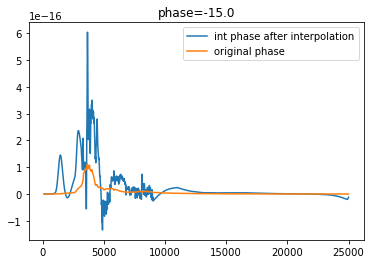

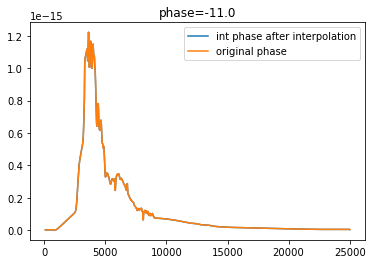

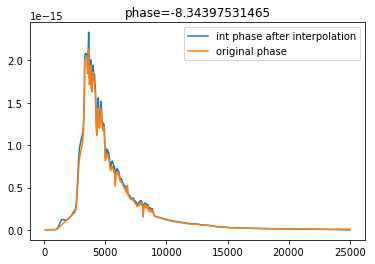

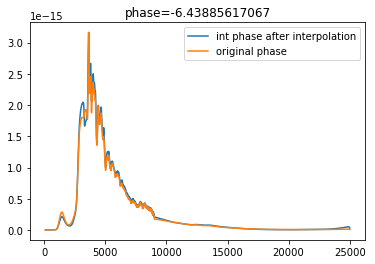

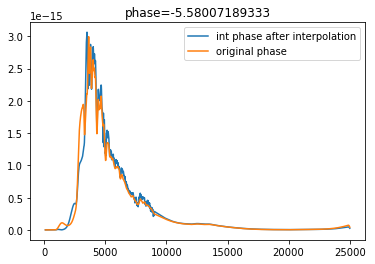

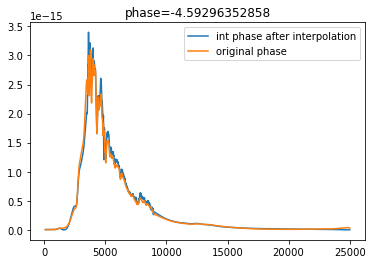

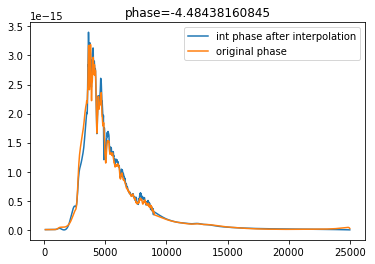

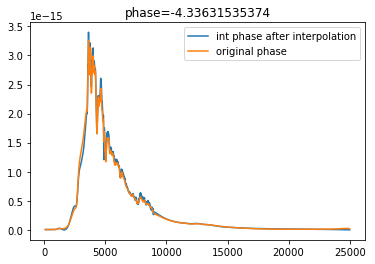

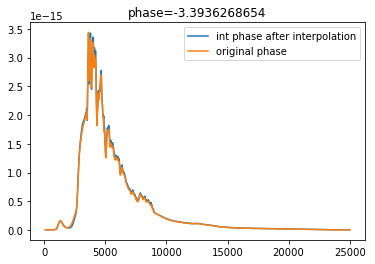

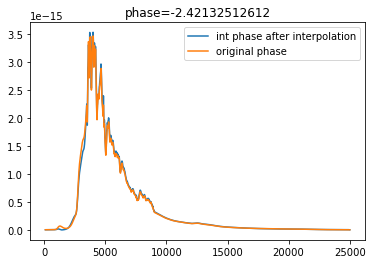

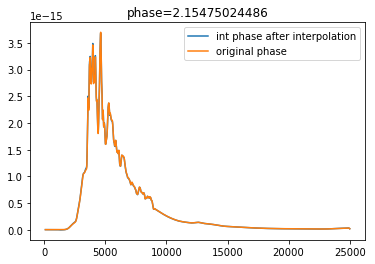

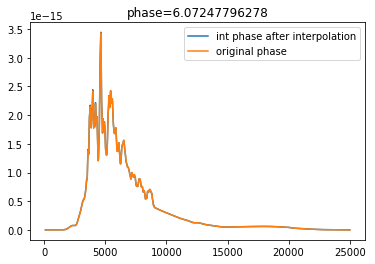

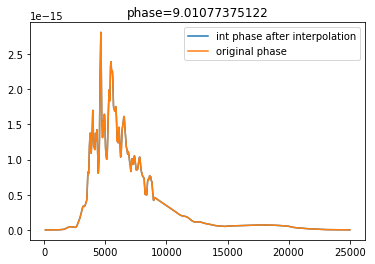

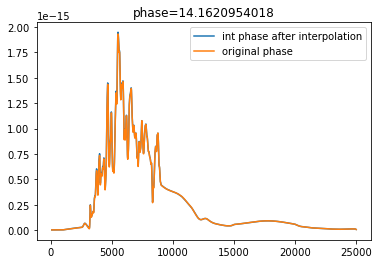

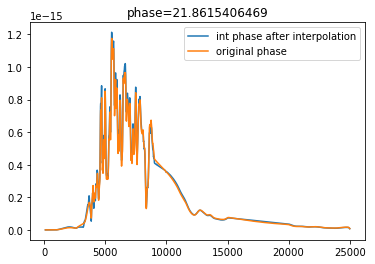

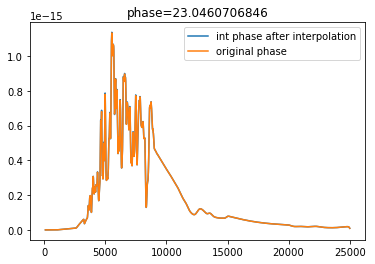

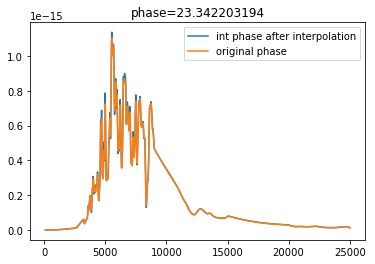

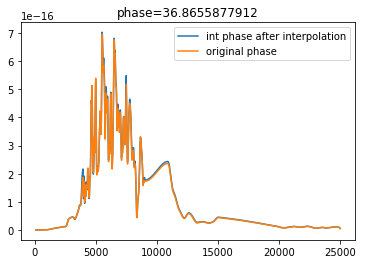

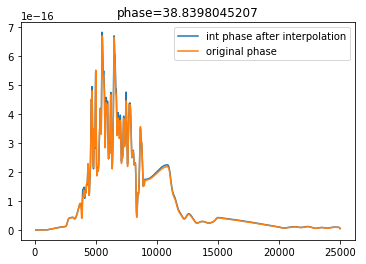

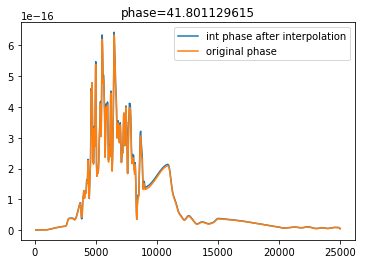

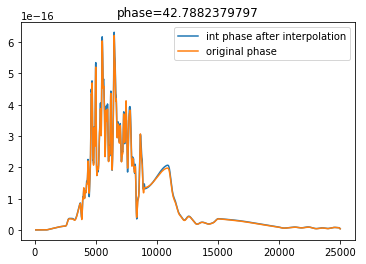

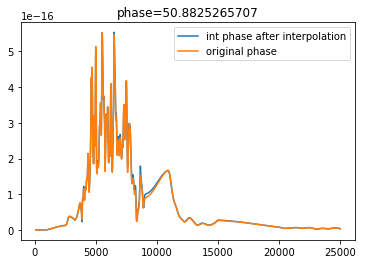

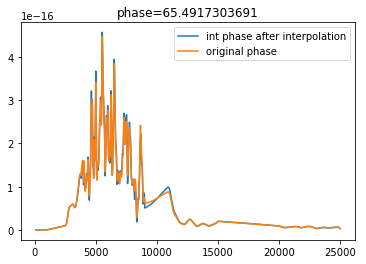

In [39]:
for i in range(0,len(sedres)):
    phase = sedres[i].phase
    plt.plot(wave,source_sncosmo.flux(int(phase),wave),label='int phase after interpolation')
    flux = sedres[i].outsed.flux(phase,wave)
    plt.plot(wave,flux,label='original phase')
    plt.legend()
    plt.title('phase={}'.format(phase))
    plt.show()

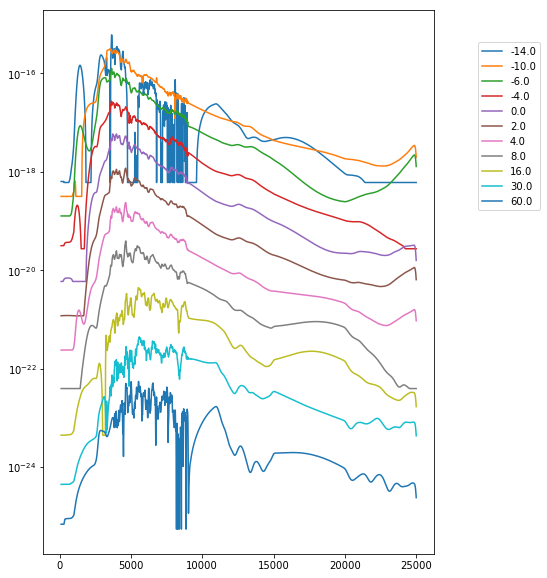

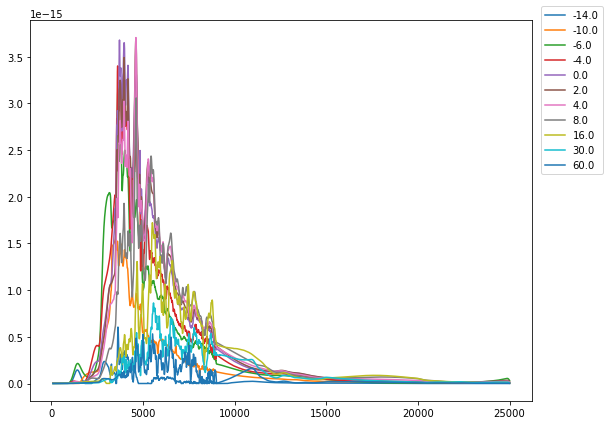

In [40]:
plt.figure(figsize=(7,10))
days = np.array([-14.,-10.,-6.,-4.,0.,2.,4.,8.,16.,30.0,60.0])
for i,d in enumerate(days):
    f = source_sncosmo.flux(d,wave)
    f = np.clip(f,np.max(f)*0.001,np.inf)
    plt.plot(wave,f / (5.**i),label=str(d))
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(2000,6000)
#plt.ylim(1e-4,1)
plt.legend(bbox_to_anchor=(1.1, 0.95))
plt.show()

plt.figure(figsize=(9,7))
days = np.array([-14.,-10.,-6.,-4.,0.,2.,4.,8.,16.,30.0,60.0])
for i,d in enumerate(days):
    f = source_sncosmo.flux(d,wave)
    f = np.clip(f,np.max(f)*0.001,np.inf)
    plt.plot(wave,f,label=str(d))
#plt.xlim(2000,6000)
#plt.ylim(1e-4,1)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

In [41]:
def define_window(wave,phase,winwavelim,winphaselim,winfunc,sym=False,**kwarg):   
    w = np.zeros(len(phase))
    fphase = np.arange(winphaselim[0],winphaselim[1]+1.,1.)
    if sym is False:
        win = winfunc(len(fphase)*2,**kwarg)
        w[:-len(fphase[fphase <= phase.max()])] = 1.
        w[len(phase)-len(fphase[fphase <= phase.max()]):] = win[len(fphase):len(fphase)+len(fphase[fphase <= phase.max()])]
    else:
        win = winfunc(len(fphase),**kwarg)
        w[:] = 1.
        w[(phase>=fphase.min()) & (phase<=fphase.max())] = win
    window2d = np.repeat(np.atleast_2d(w),len(wave)).ravel()
    wavemask = (wave<winwavelim[0]) | (wave>winwavelim[1])
    wavemask2d = np.repeat(wavemask,len(phase)).reshape(len(wavemask),len(phase)).T.ravel()
    window2d[wavemask2d] = 1.
    return window2d

In [42]:
## output interpolated SED
def gau(n,amp,std):
    return amp*signal.gaussian(n,std=std)+1.

outputsed = [-100.,0.,0.]
wave = np.arange(1000.,25005.,5.)
phase = np.arange(-15.,66.,1.)
for p in phase:
    phasearr = np.array([p]*len(wave)).ravel()
    f = source_sncosmo.flux(p,wave)
    fluxarr = np.clip(f,np.max(f)*0.001,np.inf)
    outputsed = np.vstack([outputsed,zip(phasearr,wave,fluxarr)])
outputsed = outputsed[1:,:]
winfunc = signal.exponential
w1 = define_window(wave,phase,[1000.,3000.],[10.,80.],winfunc,tau=12.)
w2 = define_window(wave,phase,[10000.,20000.],[45.,80.],winfunc,tau=100.)
w3 = define_window(wave,phase,[4000.,10000.],[60.,80.],winfunc,tau=100.)
w4= define_window(wave,phase,[3000.,4000.],[40.,70.],signal.cosine)
w5 = define_window(wave,phase,[20000.,25000.],[50.,80.],winfunc,tau=50.)
w6 = define_window(wave,phase,[8000.,9000.],[55.,65.],signal.cosine)
w7 = define_window(wave,phase,[1000.,3000.],[20.,35.],gau,amp=1.5, std=3.,sym=True)
w = w1*w2*w3*w4*w5*w6*w7
outputsed[:,2] *= w
Table(outputsed).write('sn2005hk.sed.dat',format='ascii.no_header',overwrite=True)

In [43]:
## re-feed the SED in sncosmo
wave = np.unique(outputsed[:,1])
flux = np.zeros(len(wave))
phase = []
for p in np.unique(outputsed[:,0]):
    f = outputsed[np.where(outputsed[:,0] == p),2]
    flux = np.vstack([flux,f])
    phase.append(p)
flux = flux[1:,:]
outputsource = sncosmo.TimeSeriesSource(phase,wave,flux)

In [44]:
## write out output sncosmo source
pickle_dict = {'source':outputsource}
pickle_out = open("sn2005hk.source.pickle","wb")
pickle.dump(pickle_dict, pickle_out)
pickle_out.close()

redshift=0.01306


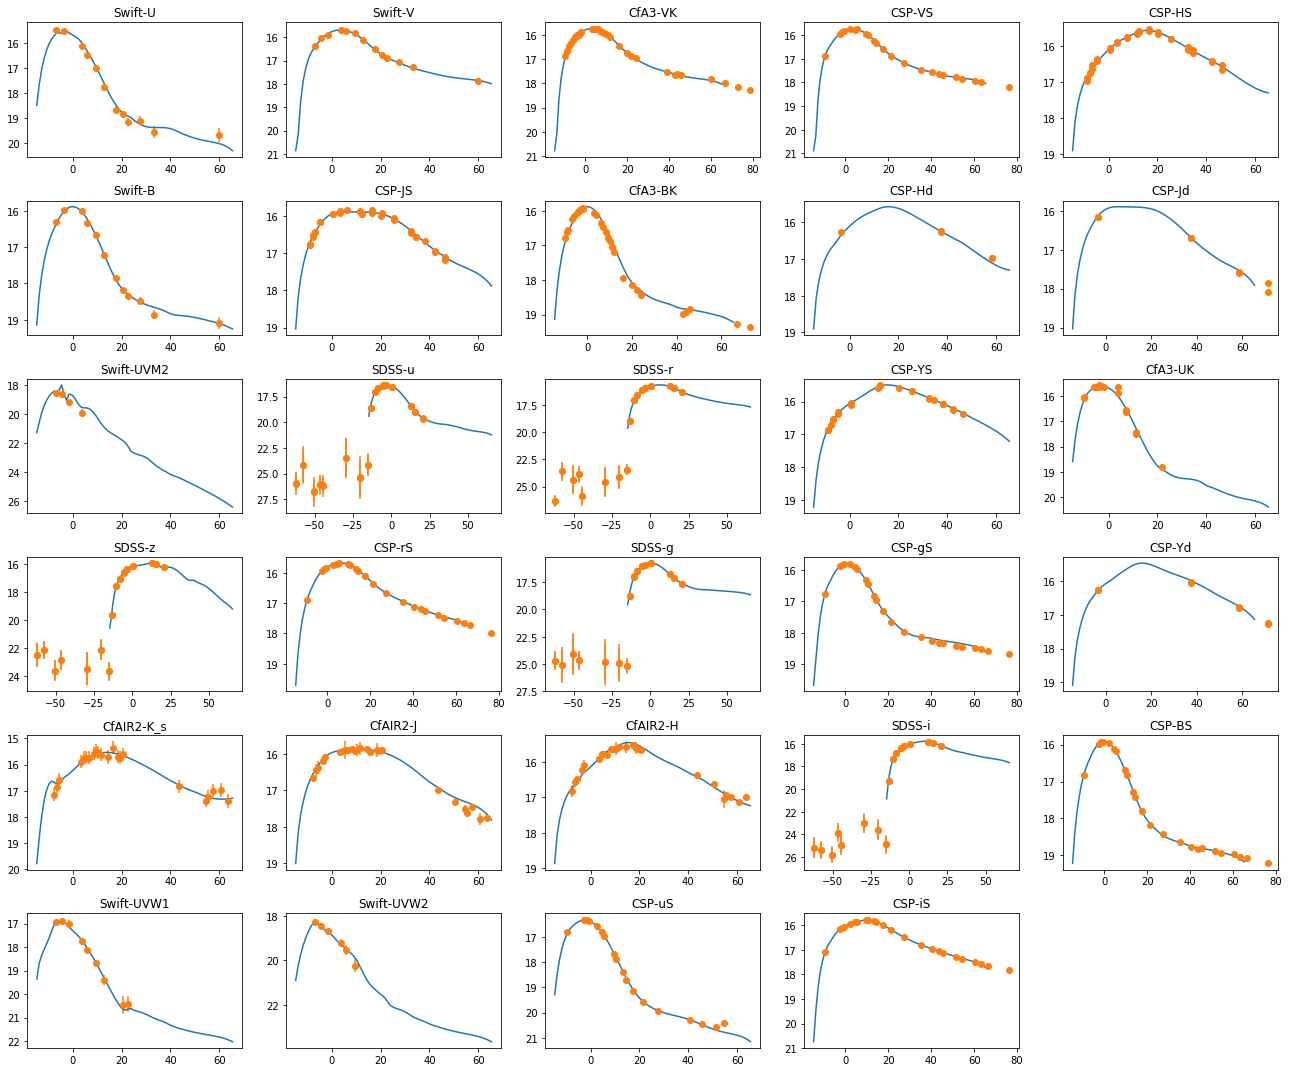

In [45]:
## plot the light curves
sedmodel = sncosmo.Model(source=outputsource)
sedmodel.set(z=redshift)
print "redshift={}".format(redshift)
synlc_phase = np.arange(-14.5,65.5,1)
fig = plt.figure(figsize=(18,15))
for i,f in enumerate(set(phot['Filter'])):
    plt.subplot(6,5,i+1)
    plt.title(f)
    band = sncosmo.get_bandpass(f)
    if band.minwave()< sedmodel.minwave() or band.maxwave()> sedmodel.maxwave():
        continue
    mref,magsys = sedfit.utils.get_refmag(f.split('-')[0],f.split('-')[-1])
    synlc_mag = sedmodel.bandmag(band,magsys,synlc_phase) + mref
    plt.plot(synlc_phase*(1.+redshift),synlc_mag)
    plt.errorbar(phot['MJD'][phot['Filter']==f]-peakmjd,phot['Mag'][phot['Filter']==f],yerr=phot['MagErr'][phot['Filter']==f],fmt='o')
    plt.ylim(plt.ylim()[::-1])
plt.tight_layout()
plt.show()


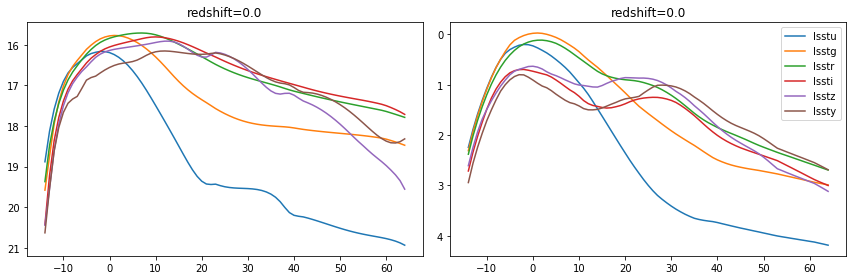

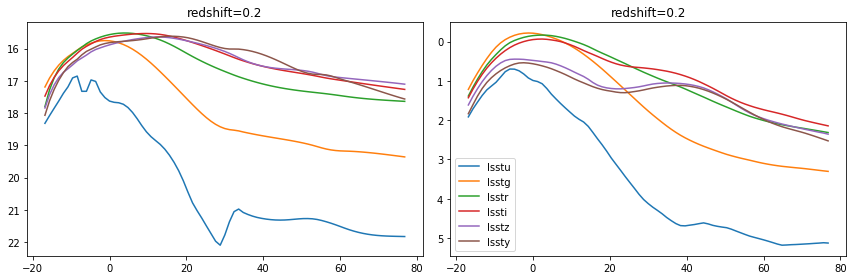

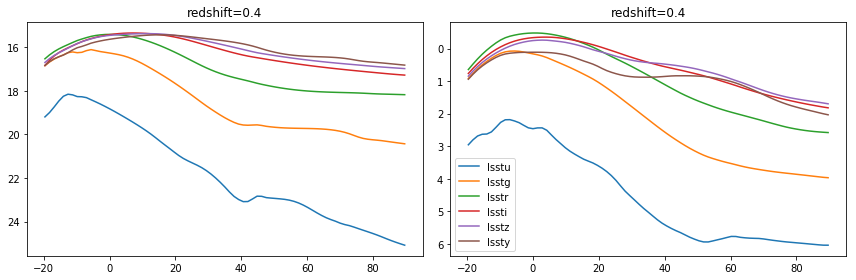

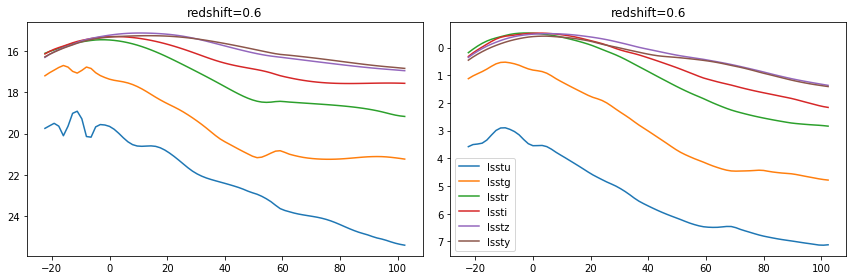

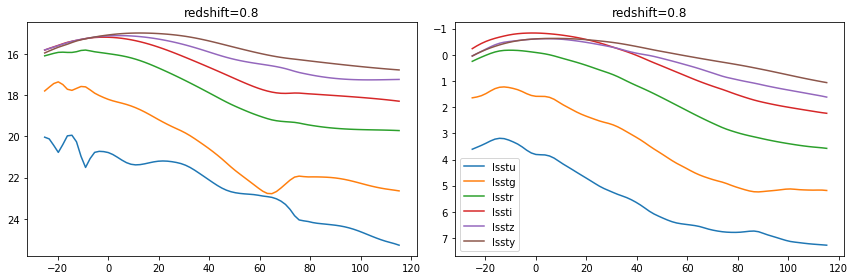

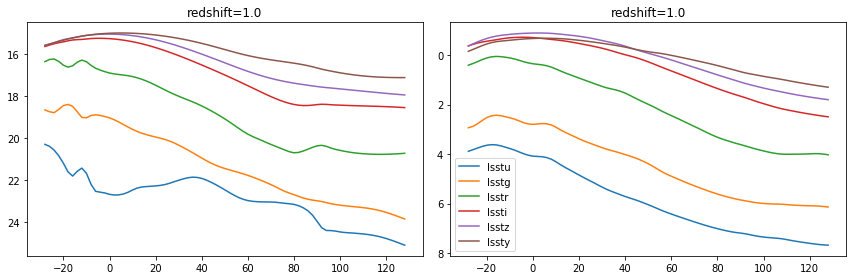

In [46]:
## synthetic light curves on LSST filters
synlc_phase = np.arange(-14,65,1)
for z in np.arange(0.,1.2,0.2):
    fig = plt.figure(figsize=(12,4))
    for filt in list('ugrizy'):
        ax1 = fig.add_subplot(1,2,1)
        sedmodel = sncosmo.Model(source=outputsource)
        sedmodel.set(z=z)
        f = 'lsst'+filt
        ax1.set_title('redshift={}'.format(z))
        band = sncosmo.get_bandpass(f)
        if band.minwave()< sedmodel.minwave() or band.maxwave()> sedmodel.maxwave():
            continue
        mref,magsys = sedfit.utils.get_refmag(f.split('-')[0],f.split('-')[-1])
        synlc_mag = sedmodel.bandmag(band,magsys,synlc_phase) + mref
        ax1.plot(synlc_phase*(1.+z),synlc_mag,label=f)
        
        ax2 = fig.add_subplot(1,2,2)
        hsed.set(z=z)
        f = 'lsst'+filt
        ax2.set_title('redshift={}'.format(z))
        band = sncosmo.get_bandpass(f)
        if band.minwave()< hsed.minwave() or band.maxwave()> hsed.maxwave():
            continue
        mref,magsys = sedfit.utils.get_refmag(f.split('-')[0],f.split('-')[-1])
        synlc_mag = hsed.bandmag(band,magsys,synlc_phase) + mref
        ax2.plot(synlc_phase*(1.+z),synlc_mag,label=f)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax2.set_ylim(ax2.get_ylim()[::-1])
        
    plt.legend()
    plt.tight_layout()
    plt.show()

        